### V. Algorithm Selection and fine tuning

In this part, we create a model, we try different algorithms and see which one delivers the best results. Then we chose the best algorithm and fine tune it. 

This notebook presents the following parts:

1) Model creation
* Split dataset on train and test sets, making sure that countries with duplicates are in either the train or the test set. 
* After Splitting, I deal with collinearity issues by removing columns.        

2) Algorithm testing : 
* Linear Regression 
* Boosted decision tree regressor
* Random forest regressor
* Bayesian linear regressor
3) Chosing best algorithm

4) Improving the algorithm

5) Save model

6) Verification that the **model created will generalize well** (visualizations, etc.)

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from tabulate import tabulate

%matplotlib inline
%matplotlib inline

In [2]:
#import data set
df=pd.read_csv('dfprepared2.csv')
df.shape

(860, 39)

In [3]:
df.head(2)

,access_to_electricity,access_to_improved_sanitation,access_to_improved_water_sources,agricultural_land_area,anemia_prevalence,avg_supply_of_protein_of_animal_origin,avg_value_of_food_production,caloric_energy_from_cereals_roots_tubers,cereal_import_dependency_ratio,cereal_yield,...,rural_share,total_labor_force,total_land_area,total_population,trade_in_services,unemployment_rate,urban_share,Deacade:_2000,Deacade:_2010,prevalence_of_undernourishment
0,0.131209,0.044677,-0.534437,-0.280310,0.419850,-0.542188,0.402156,1.350589,0.166395,0.504589,...,0.603808,-0.243936,-0.209913,-0.249191,-0.54502,-1.121657,-0.684934,0,1,18.298233
1,0.557962,0.782137,0.900896,-0.299954,-0.349091,1.366352,-0.576278,-1.062279,0.950054,-0.380889,...,0.826154,-0.297878,-0.292849,-0.290334,2.30482,-1.150862,-0.834617,1,0,39.513397


In [4]:
df.columns

Index(['access_to_electricity', 'access_to_improved_sanitation',
       'access_to_improved_water_sources', 'agricultural_land_area',
       'anemia_prevalence', 'avg_supply_of_protein_of_animal_origin',
       'avg_value_of_food_production',
       'caloric_energy_from_cereals_roots_tubers',
       'cereal_import_dependency_ratio', 'cereal_yield', 'co2_emissions',
       'country_code', 'fertility_rate',
       'food_imports_as_share_of_merch_exports', 'forest_area',
       'gross_domestic_product_per_capita_ppp',
       'imports_of_goods_and_services', 'life_expectancy',
       'military_expenditure_share_gdp', 'net_oda_received_per_capita',
       'net_oda_received_percent_gni', 'obesity_prevalence', 'open_defecation',
       'per_capita_food_production_variability',
       'per_capita_food_supply_variability',
       'percentage_of_arable_land_equipped_for_irrigation',
       'political_stability', 'population_growth',
       'proportion_of_seats_held_by_women_in_gov', 'rural_share

In [5]:
df.shape

(860, 39)

### 1. Model Creation

Here it is very important to know what I am doing. 

Given the number of countries are limited 92, and they are not the same in the train as in the test data. 

When doing the local train/test split, it is imperative that I split the data by country so that all years of data for a country appear either in the train set or the test set, but are not split across both.

The country codes in the test set are distinct from those in the train set. In other words, no country that appears in the train set appears in the test set. Thus, country-specific features (i.e. country dummy variables) will not be an option. However, the countries in the test set still share similar patterns as those in the train set and so other feature engineering will work the same as usual.

Consequently, I proceed as follows:

* Identify unique country codes
* Split train and test data:
        - Train data will have some country codes
        - Test data will have the other country codes
* Finally, I drop the country_code column from both train and test data

In [6]:
df.country_code.unique()

array(['9e614ab', '100c476', '4609682', '7e222a7', '583201c', '2ddc563',
       'b79b5f9', 'c408d26', 'e256731', 'a0b37e7', 'd090b87', '6966b4a',
       'e509cda', '04952a0', '893d538', 'c8e4701', 'f405b98', '10aeba6',
       '0b6e276', '2e5e810', 'ba2039a', '6303e84', '71dc81f', 'd680446',
       '75c02b8', 'c3782c8', '81e884c', '5f1162c', 'e8739c8', '085807f',
       'c3668f5', '9621c07', '0845041', 'ee5721a', '30e2302', '6b615ad',
       'e15a18a', '7fb4d17', '0c0177b', '8e8dfae', 'ba8e2c5', '5c83a63',
       '611025c', '1881055', 'ea0b937', '889f053', '2f1d47e', '679c02d',
       'c9d2604', '22b9653', '42c298b', '6e49e65', 'a7d355b', 'ea3bfc2',
       '94e6bd5', '07f8d11', '066b021', '3e049d7', '75e8f46', '99a7c06',
       '9e79f12', '12c8f8f', '8fb5447', '2ca26c6', '11c9833', '7328d3f',
       '45a15a2', '66b86bf', '0593aa0', '508731a', 'be60011', '5dbddf9',
       'efa9150', 'e8bfe1e', '5c2e474', 'b3dfc85'], dtype=object)

In [7]:
#To select rows whose column value is in an iterable array, which we'll define as array, you can use isin:
array = ['889f053', '9e614ab', '100c476', '4609682', 'be2a7f5', '7e222a7',
       '066b021', '66b86bf', '583201c', '0ea781c', '2ddc563', 'b79b5f9',
       'f787860', '4080343', 'c408d26', 'e256731', '99a7c06', 'a0b37e7',
       'd090b87', '6966b4a', '79c89fd', '12c8f8f', '3e049d7', 'e509cda',
       'abd1492', '04952a0', '5dbddf9', '893d538', 'd3a0eeb', 'c8e4701',
       'f405b98', '5c2e474', '10aeba6', '0b6e276', '2e5e810', '0593aa0',
       'ed9ad13', 'ba2039a', '6303e84', '71dc81f', 'd680446', '11c9833',
       '75c02b8', 'c3782c8', '81e884c', '5f1162c', 'e8739c8', '085807f',
       'ba8e2c5', 'cff4c58', 'c3668f5', 'e8bfe1e', '9621c07', '93d74a6',
       '0845041', 'dd64913', '9e79f12', 'ee5721a', '30e2302', '6b615ad',
       'e15a18a', '7fb4d17', '0c0177b', '8fb5447', ]
train = df.loc[df['country_code'].isin(array)]
train.shape

(604, 39)

In [8]:
# for test values, we shall use the sing ~ to select those country codes NOT IN array
test = df.loc[~df['country_code'].isin(array)]
test.shape

(256, 39)

In [9]:
#Now I can delete the country_code column from train and test:
train= train.drop(['country_code'], axis = 1)
test= test.drop(['country_code'], axis = 1)

In [10]:
X_train = train.loc[:, train.columns != 'prevalence_of_undernourishment']
X_test = test.loc[:, test.columns != 'prevalence_of_undernourishment']
y_train = train['prevalence_of_undernourishment']
y_test = test['prevalence_of_undernourishment']

Before I continue, I check for columns to be dropped because of collinearity

In [11]:
import numpy as np
import pandas as pd
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X_train, thresh=5.0):
    variables = [X_train.columns[i] for i in range(X_train.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X_train[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X_train[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X_train[[i for i in variables]]

X = X_train # Selecting your data

X_train = calculate_vif_(X_train,5) # Actually running the function

37


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:    4.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  36 | elapsed:    0.0s remaining:    0.5s


Thu Apr 18 10:38:07 2019 dropping 'rural_share' at index: 28
36


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  35 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Thu Apr 18 10:38:07 2019 dropping 'total_labor_force' at index: 28
35
Thu Apr 18 10:38:07 2019 dropping 'fertility_rate' at index: 11
34


[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  33 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Thu Apr 18 10:38:08 2019 dropping 'access_to_electricity' at index: 0
33
Thu Apr 18 10:38:08 2019 dropping 'access_to_improved_sanitation' at index: 0
32


[Parallel(n_jobs=-1)]: Done   4 out of  32 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  31 | elapsed:    0.0s remaining:    0.6s


Thu Apr 18 10:38:08 2019 dropping 'total_land_area' at index: 25
31
Thu Apr 18 10:38:08 2019 dropping 'life_expectancy' at index: 13
30
Remaining variables:
[['access_to_improved_water_sources', 'agricultural_land_area', 'anemia_prevalence', 'avg_supply_of_protein_of_animal_origin', 'avg_value_of_food_production', 'caloric_energy_from_cereals_roots_tubers', 'cereal_import_dependency_ratio', 'cereal_yield', 'co2_emissions', 'food_imports_as_share_of_merch_exports', 'forest_area', 'gross_domestic_product_per_capita_ppp', 'imports_of_goods_and_services', 'military_expenditure_share_gdp', 'net_oda_received_per_capita', 'net_oda_received_percent_gni', 'obesity_prevalence', 'open_defecation', 'per_capita_food_production_variability', 'per_capita_food_supply_variability', 'percentage_of_arable_land_equipped_for_irrigation', 'political_stability', 'population_growth', 'proportion_of_seats_held_by_women_in_gov', 'total_population', 'trade_in_services', 'unemployment_rate', 'urban_share', 'Deaca

[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


So now I know I have to drop to avoid collinearity the following columns: 
- 'fertility_rate', 'access_to_improve_sanitation','access_to_electricity','total_labor_force'
- 'agricultural_land_area' , 'total_land_area' , 'rural_share', 'total_population' 

In [12]:
df = df.drop(['fertility_rate', 'access_to_improved_sanitation','access_to_electricity','total_labor_force','agricultural_land_area' , 'total_land_area' , 'rural_share', 'total_population'], axis=1)

In [13]:
X_train = train.loc[:, df.columns != 'prevalence_of_undernourishment']
X_test = test.loc[:, df.columns != 'prevalence_of_undernourishment']
y_train = train['prevalence_of_undernourishment']
y_test = test['prevalence_of_undernourishment']

### 2. Algorithm Testing

#### 2.1 Linear Regression 

##### 2.1.1 Linear Regression simple

In [14]:
#Train the Model and predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_predictions = lm.predict(X_test)

In [15]:
#print RMSLE
print ('Simple Regression RMSE is', np.sqrt(mean_squared_error(y_test, lm_predictions)))


Simple Regression RMSE is 7.68311241033786


2.2 Algorithm: **Boosted Decision Tree Regressor**

In [16]:
#Train the Model and predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
Tree = DecisionTreeRegressor()
Tree.fit(X_train,y_train)
Tree_predictions = Tree.predict(X_test)

In [17]:
#print RMSLE
print ('Boosted Decision Tree Regression RMSE is', np.sqrt(mean_squared_error(y_test, Tree_predictions)))

Boosted Decision Tree Regression RMSE is 9.759306901091692


2.3 Algorithm: **Random Forest Regressor**

In [18]:
#Train the Model and predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
Forest = RandomForestRegressor()
Forest.fit(X_train,y_train)
Forest_predictions = Forest.predict(X_test)

C:\Users\Florence\Anaconda333\envs\xebiamow\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
#print RMSLE
print ('Random Forest Regression RMSE is', np.sqrt(mean_squared_error(y_test, Forest_predictions)))

Random Forest Regression RMSE is 7.954663837692167


2.4 Algorithm: **Bayesian Linear Regressor**

In [20]:
#Train the Model and predict
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
Bayesian = BayesianRidge()
Bayesian.fit(X_train,y_train)
Bayesian_predictions = Bayesian.predict(X_test)

In [21]:
#print RMSLE
print ('Bayesian Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Bayesian_predictions)))

Bayesian Ridge Regression RMSE is 7.111954863883175


### 3. Compare and chose best model

In [22]:
print ('Simple Regression RMSE is', np.sqrt(mean_squared_error(y_test, lm_predictions)))
print ('Boosted Decision Tree Regression RMSE is', np.sqrt(mean_squared_error(y_test, Tree_predictions)))
print ('Random Forest Regression RMSE is', np.sqrt(mean_squared_error(y_test, Forest_predictions)))
print ('Bayesian Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Bayesian_predictions)))

Simple Regression RMSE is 7.68311241033786
Boosted Decision Tree Regression RMSE is 9.759306901091692
Random Forest Regression RMSE is 7.954663837692167
Bayesian Ridge Regression RMSE is 7.111954863883175


Clearly, **LASSO REGRESSION** is the one producing the best results

## 4. Improving the model

##### 4.1 Lasso Linear Regression (l1)

In [23]:
#Train the Model and predict
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
Lasso = Lasso()
Lasso.fit(X_train,y_train)
Lasso_predictions = Lasso.predict(X_test)

In [24]:
#print RMSLE
print ('Lasso Regression RMSE is', np.sqrt(mean_squared_error(y_test, Lasso_predictions)))

Lasso Regression RMSE is 6.282752995392041


#### 4.2  Ridge Regression (l2)

In [25]:
#Train the Model and predict
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
Ridge = Ridge()
Ridge.fit(X_train,y_train)
Ridge_predictions = Ridge.predict(X_test)

In [26]:
#print RMSLE
print ('Ridge Regression RMSE is', np.sqrt(mean_squared_error(y_test, Ridge_predictions)))

Ridge Regression RMSE is 7.511053345047911


## 5. Save the model for future predictions

In [27]:
# Saving LogRec model
from sklearn.externals import joblib
from joblib import dump, load

In [28]:
dump(Lasso,'Lasso.joblib') 

['Lasso.joblib']

## 6. Verification that the model created will generalize well

In [29]:
def print_metrics(y_train, y_test, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_train, y_test)
    r2_adj = r2 - (n_parameters - 1)/(y_train.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_train, y_test)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_test))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_train, y_test)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_train, y_test)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = Lasso.predict(X_test) 
print_metrics(y_test, y_score, 40)

Mean Square Error      = 39.47298520110766
Root Mean Square Error = 6.282752995392041
Mean Absolute Error    = 5.252111763142474
Median Absolute Error  = 4.8100178276705705
R^2                    = 0.47873777076928503
Adjusted R^2           = 0.38462097938040596


In [30]:
#Lets look at the residuals plot 

## Calculate residuals (y-yhat)
df['residuals']=y_train - y_test

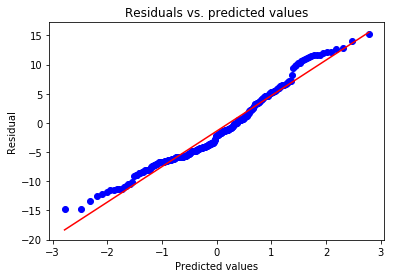

In [31]:
def resid_qq(y_train, y_test):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids, plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_train, y_test)   

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the straight line). This is particularly for large residuals.

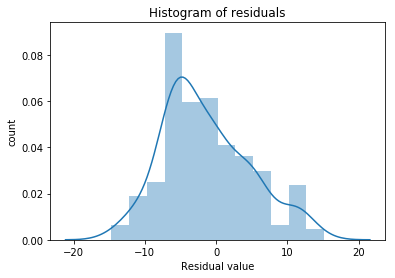

In [32]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score) 

This plot looks reasonable. The residual values are distributed near both sides of 0.

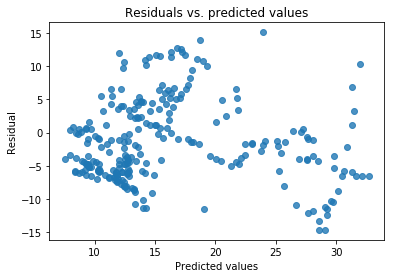

In [33]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score)

As expected, when plotting residuals we cannot see any clear pattern. Otherwise it would mean there is a hidden pattern we could not identify.

We can see, however, some outliers mainly positive.

### 6. Oportunity for improvement

Clearly, an opportunity for improvement would be to deal with outliers. 

Look at all the country codes one by one, and search for irregularities. 

This project was part of a competition, in which my result scored 17th best on the competiton. Later, with time, I could work and improve the results, matching the best algorithm results. See [here]( https://datasciencecapstone.org/competitions/9/predicting-chronic-hunger/leaderboard/)